## S2 To R1 Attractor + R1 Obstacle Avoidance

In [2]:
using PBDS, StaticArrays, LinearAlgebra, GeometryBasics, Rotations, BenchmarkTools

┌ Info: Precompiling PBDS [5f01a6e0-657c-4950-bc4f-54ae38a49d4c]
└ @ Base loading.jl:1278


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5208503456544894273\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12447078840069216614\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5208503456544894273\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Setup

### Point Attractor

In [3]:
PBDS.task_map_emb(::EmbRep, ::EmbRep, xme, task_map::DistanceFromPoint{S2,R1}) where n = SA[norm(xme - task_map.position_center)]
PBDS.domain_coord_rep(::DistanceFromPoint{S2,R1,S}) where S = EmbRep()

PBDS.metric_chart(xn, task::Attractor{<:DistanceFromPoint{S2,R1,S}}, CN::Chart{1,R1}) where S = 
    default_metric(xn, task, CN)
PBDS.potential_chart(xn, task::Attractor{<:DistanceFromPoint{S2,R1,S}}, CN::Chart{1,R1}) where S = xn[1]^2
PBDS.dissipative_forces_chart(xn, vn, task::Attractor{<:DistanceFromPoint{S2,R1,S}}, CN::Chart{1,R1}) where S =  0*vn
PBDS.weight_metric_chart(xn, vn, task::Attractor{<:DistanceFromPoint{S2,R1,S}}, CN::Chart{1,R1}) where S = 
    default_weight_metric(xn, vn, task, CN)

### Sphere Damping

In [4]:
PBDS.default_coord_rep(::Damping{<:Identity{S2,S2,S}}) where S = EmbRep()
PBDS.metric_emb(xne, task::Damping{<:Identity{S2,S2,S}}) where S =
    default_metric(xne, task)
PBDS.potential_emb(xne, task::Damping{<:Identity{S2,S2,S}}) where S = 0.
PBDS.dissipative_forces_emb(xne, vne, task::Damping{<:Identity{S2,S2,S}}) where S = -4*vne
PBDS.weight_metric_emb(xne, vne, task::Damping{<:Identity{S2,S2,S}}) where S =
    default_weight_metric(xne, vne, task)
PBDS.home_task_chart(task::Damping{<:Identity{S2,S2,S}}) where S = Chart{SterProjSouth,S2}()

### Sphere Avoidance

In [5]:
PBDS.domain_coord_rep(::DistanceFromSphereSurface{S2,R1,S}) where S = EmbRep()
PBDS.task_map_emb(::EmbRep, ::EmbRep, xme, task_map::DistanceFromSphereSurface{S2,R1}) =
    SA[abs(norm(xme - task_map.center) - task_map.radius)]

function PBDS.metric_chart(xn, task::CollisionAvoidance{<:DistanceFromSphereSurface{S2,R1,S}}, CN::Chart{1,R1}) where S
    ψx = exp(1.e0 / xn[1]^2)
    G = SMatrix{1,1,eltype(xn)}([ψx])
end
PBDS.potential_chart(xn, task::CollisionAvoidance{<:DistanceFromSphereSurface{S2,R1,S}}, CN::Chart{1,R1}) where S = 0.
PBDS.dissipative_forces_chart(xn, vn, task::CollisionAvoidance{<:DistanceFromSphereSurface{S2,R1,S}}, CN::Chart{1,R1}) where S = 0*vn
function PBDS.weight_metric_chart(xn, vn, task::CollisionAvoidance{<:DistanceFromSphereSurface{S2,R1,S}}, CN::Chart{1,R1}) where S
    offset_distance = 5.
    λ = (xn[1] < offset_distance && vn[1] < 0.) ? 1. : 0.
    W = SMatrix{1,1,eltype(xn)}(I)*λ
end

# <span style="color:red">Sid: adjust tasks below to test out things</span>.

In [13]:
M = S2
CM = Chart{SterProjNorth,S2}()
tasks, CNs = TaskList(), ChartList()

N = R1
CN = Chart{1,N}()
# center = SA[1., -1., -1.]
center = SA[1., -1., 1.]
center = center ./ norm(center)
push!(tasks, Attractor(DistanceFromPoint{M,N}(center)))
push!(CNs, CN)

N = S2
CN = Chart{SterProjSouth,S2}()
push!(tasks, Damping(Identity{M,N,Float64}()))
push!(CNs, CN)

N = R1
CN = Chart{1,N}()
obs_centers = []
obs_radii = []

push!(obs_centers, SA[1., 1.2, 0.8])
push!(obs_radii, 0.4)

push!(obs_centers, SA[-0.2, 0.2, 1.])
push!(obs_radii, 0.3)

push!(obs_centers, SA[0.2, -0.2, -1.])
push!(obs_radii, 0.3)

push!(obs_centers, SA[-1.2, 1., -0.8])
push!(obs_radii, 0.4)

push!(obs_centers, SA[-1.2, -0.9, -0.1])
push!(obs_radii, 0.3)

for i in 1:length(obs_centers)
    obs_centers[i] = (obs_centers[i] / norm(obs_centers[i])) * (1. - obs_radii[i]/2)
    push!(tasks, CollisionAvoidance(DistanceFromSphereSurface{M,N}(obs_centers[i], obs_radii[i])))
    push!(CNs, CN)
end

In [14]:
# Initial state
xme = SA[-1., 1., 1.]
xme = xme ./ norm(xme)
vme = SA[2., 1., 1.]

robot_coord_rep = EmbRep()
σxddot, = multiple_task_acceleration(xme, vme, tasks, CM, CNs, robot_coord_rep)

([-8.596221534079968, -5.50614251359964, -13.482383865893585], Chart[])

## Single Trajectory

In [15]:
using Plots, Makie, Observables, ProgressMeter, ColorSchemes

In [16]:
Time = 40
dt = 0.01

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjNorth,S2}()
traj_north = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjSouth,S2}()
traj_south = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) =
    (pe[3] < 0)[1] ? Chart{SterProjSouth,S2}() : Chart{SterProjNorth,S2}()
traj_switching = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)
traj_switching.xm[end]

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
  0.5773502691896213
 -0.577350269189629
  0.5773502691896271

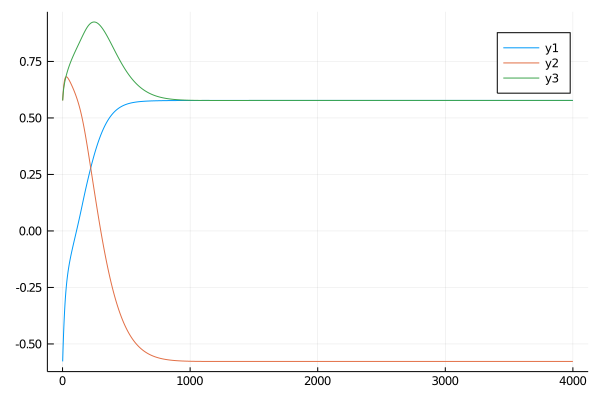

In [17]:
Nplot = length(traj_switching.xm)
Plots.plot(getindex.(traj_switching.xm,1)[1:Nplot])
Plots.plot!(getindex.(traj_switching.xm,2)[1:Nplot])
Plots.plot!(getindex.(traj_switching.xm,3)[1:Nplot])

In [18]:
ax_size, plot_size = 1, 800
scene = Scene(resolution = (plot_size, plot_size))
mesh!(Sphere(Point3(zeros(3)), 1.), color = RGBA(1.,1.,1.,0.7), transparency = true)
for i in 1:length(obs_centers)
    mesh!(Sphere(Point3(obs_centers[i]...), obs_radii[i]), color = RGBA(0.,1.,0.,0.4), transparency = true)
end
Makie.scatter!(scene, [xme[1]], [xme[2]], [xme[3]], markersize = ax_size/20, color = :blue)
δ = 0.99
Makie.scatter!(scene, [center[1]*δ], [center[2]*δ], [center[3]*δ], markersize = ax_size/20, color = :green)

linewidth = 1.5
Makie.lines!(scene, getindex.(traj_switching.xm,1), getindex.(traj_switching.xm,2), getindex.(traj_switching.xm,3), color = :purple, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_south.xm,1), getindex.(traj_south.xm,2), getindex.(traj_south.xm,3), color = :red, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_north.xm,1), getindex.(traj_north.xm,2), getindex.(traj_north.xm,3), color = :blue, linewidth = linewidth)

Makie.xlims!(scene, (-ax_size, ax_size))
Makie.ylims!(scene, (-ax_size, ax_size))
Makie.zlims!(scene, (-ax_size, ax_size))
axis = scene[Axis]
axis.showaxis = false
rotate_cam!(scene, 0.4, 0., 0.)
display(scene)

GLMakie.Screen(...)

## Multiple Trajectories

In [11]:
Time = 18
dt = 0.05

θ = collect(0:π/25:2π)
ntraj = length(θ) - 1

vm_gen = []
for i in 1:ntraj
    R = AngleAxis(θ[i], xme...)
    push!(vm_gen, R*vme)
end

trajs = Array{Any}(undef, ntraj)
p = Progress(ntraj)

Threads.@threads for i in 1:ntraj
    trajs[i] = propagate_tasks(xme, vm_gen[i], tasks, CM, CNs, Time, dt, robot_coord_rep)
    next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [1]:
iobs = Observable(1)

ax_size, plot_size = 1, 800
limits = FRect3D((-ax_size, -ax_size, -ax_size), (2*ax_size, 2*ax_size, 2*ax_size))
scene = Scene(resolution = (plot_size, plot_size))

mesh!(Sphere(Point3(zeros(3)), 1.), color = RGBA(1.,1.,1.,0.0))
for i in 1:length(obs_centers)
    color = RGBA(0.95,0.6,0.3,1.) # Orange
    mesh!(Sphere(Point3(obs_centers[i]...), obs_radii[i]), shininess = 8.0f0, specular = Vec3f0(0.15); color)
end
for i = 1:ntraj
    color = get(ColorSchemes.vikO, θ[i]/(2π))
    Makie.lines!(scene, getindex.(trajs[i].xm,1), getindex.(trajs[i].xm,2), getindex.(trajs[i].xm,3); color, linewidth = 2)
    Makie.scatter!(scene, lift(j -> [trajs[i].xm[j][1]], iobs), lift(j -> [trajs[i].xm[j][2]], iobs), lift(j -> [trajs[i].xm[j][3]], iobs), markersize = ax_size/20; color)
end
Makie.scatter!(scene, [center[1]*δ], [center[2]*δ], [center[3]*δ], markersize = ax_size/15, color = :green)

Makie.xlabel!(scene, "x")
Makie.ylabel!(scene, "y")
axis = scene[Axis]
axis.showaxis = false
rotate_cam!(scene, 0.4, 0., 0.)
display(scene)

LoadError: UndefVarError: Observable not defined

In [17]:
function record_scene(scene, filename, iobs, N, framerate=60)
    p = Progress(N)
    record(scene, filename, 1:N) do i
        iobs[] = i
        rotate_cam!(scene, 0.015, 0., 0.)
        next!(p)
    end
    display("text/html", html_video(filename))
end

filename = "S2_To_R1Attractor_S2Damping_R1ObstacleAvoidance.mp4"
record_scene(scene, filename, iobs, length(trajs[1].xm))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQA2TC1tZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjQgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAI4oZYiEACv//vbw/gU2O5jQlxHN6J0zH78VuLo0N73OAAFo8gAAAwAAAwBs/jJZT4aXOlbMaAAAAwAI+AGTAawDK4n4OBIAXycn31rsxk3E3DGM9i39xlhEGpfZiRJJuoP4Sp8jrn3yvButMUq2ZfjyRvOl5ELX7NbZ0rvy+EhzLCNLHZhcyO9a24V1SIRnfSG45F1GCq3y6RpEZ7Rv7Zk6vLr32GFPcNvkQwfii//XXZlG6//sGIBK0Qe5AuORi+jNtXmCfFYMYeBSSX2FnDJodWlDSY3aZWL4FuRo2psou1/ah6iHheBlPZmAyGduOTsxOnNG6LudgiFj9iwqkTuyupO4lPA1wKtKV9qzhOACF49cfV+qdACFvbghL5OcVsaFqO+HmGhu3owxujmVF1DenRJgQGGnbRcqisz02CZVYWjlr5/lbknotEVibFY45NFcFwGJw/++q9HHU7zBCGuRALvzwz3II8rfMpOHs26foyLVmpxv2lp4ofwLMqXZT5Lz6+DIvMeoe9L4sVjPCLw6dmvg4HuzyRtqvTCu23cqf1HGvaUYdjDiOHpUS6GhJcjaVv4LYwYzTD7ajbu7SCIGrAlddE2KybdVaqnLbRsg2J2TAjJe5qyLtM+dyH1Jq5yxE6jrC62KgpaQeOFrUV/46Ow5kdjxLbL+fZauNxI2xeIIoDAYogpB+8YetW72xXUTjYzyKloFLwvlw/6ay9kowq8kasAZw9cwplaT2nvUN++PBB1IMU31xiXtD5OldMYjKvqDiy2CJAdvroMXg6LXmemAsaWO3587hftm+e8bET+4jBP6tqtv36fQbcehi0IMlWYdDToe4EYOrcKhAZsRLAAH4UcVWRmQjfRbPGZm6vWdjDrbD+mkS3Pj24wZPL4M7FpjWc7rDAwnRDYu3QeiwkHsmhrYewQW2fGyBMcu/q++UdIveGA2jMsP0dA10oKLr+QquOVUyYAoh6VZdcd+3ssqqMPdNbZlJLEZZk3or87ZVr/1Heiuq9dGJkCUxHayB2nPV/8x0zqdec0XlW7QPOLmCzSRa1IPzX2vtoQB0gT+ZLBS/K2dUD2rV4l5Ak+BrBFtNUl4Q4XAGVj2E8K55E1gyx/gRqehULzHysUiHUNjWKuJy3Tp+4KOMzp5ptYQ4cX+NFAw1T7hCxuMUDhlSMegM+c9ScDzr07Duf+4cmZuYWvUACYSD0YJkC4z/WdZcf/5XW4ixdeBPFnESJBfPQ2eagVvEP90ybUhdvbbruVmz9WtdHt6p2exClIWlauS2ZLeUgBLQhxcL+zDqovH5Abyhx3S5Hf3tFmkw2tWfaneZ6UB0Q3J0kUPMwnkkMPv1qtxOgH1dc5JuwE14eHdN5VJd3Kfj/udr2XO70fyhzm3+hd10PLiW+rPnh7Cv3Sj78+xiRl5cycn8qkGahDvrWxoFG7gn+TK+JlIziQCe1pvleJ7JSbegtN9nvO+4ZjA8ISDwKFsKqt+le2poHL4am+jjEbN1eeCp2d7G0cl34wVJrpI8DtdXNYSiuABO0Cnt2FgwI9AAMpsjb850CWutss0D4TlUHWN2JdH6w6gFHlyeoourELCaxQmdjtpmlsZpIInN7w4IAdYVgyn98B4NE0BdiTpK9OTfttnmtPq0G1mGVeshwv4vBEXtOOyjVC5wd4ZazGmZNeUFBn4CenvvbQuTqXUlM0PBJmLmVp0bnqEInxZyrddskoqQHTXon5+5txgVtgyHE17ZT2F72n73tjvo+nvW6nmgXmkoDbHqQmRfCwyHM018TQVAERhILBLOCcWsLIwLmcogKFudXQPeTOikNjzYBzqHcrH6XgzdpRcZQAtJ1F9Ah1A8ksEP97siMaLY1LZAkNmEI4k4Xb5TRgIfaBDy1glQ/PZTcMBqGqwhIp6seuGWQOSH6Ara6WCYYyb6EW82zPqmLQg5iewzm99RKvb06XCizMG6c1qq3UMz6gzs5kD186xF2fBEhv0LFo3IAWrtqLZbXHtXW+867rRe+2XfWDz6ijj+6aPdghMf/68G7URNdKinCgKB2IXzRolZzLjR8yWXfMOn2q3RE21iR0mE6Oydd2KEVt+dh9ltwmaNdxuo9vKI+aAwN2iNAewhn+DGV5VQzx7M/rVLV0BlCuohSWZgyZMnjoYSxpeJXDi4H/P/RYgvXrmSreIZ+PrjlSt6zmVwkb/5dNnsN4ducnXNR2R5DTs7AVNA/XmK/R/w33q/ITRU9j8EBJTBRqPh9DlXRR5Z5gcj6LOC2sjwQvkWMwAQ06/LgZtmDWXAo5xZ5cMLeOf4RLVIALQzlc60CrfpZW/yEa4DZHQKpIzA+Q5YOemsWtnosKkzzkkFKHrr7+2gk/9fca4AO9aveNfGLF6gBFBQl7IC/i/4F0eMRXI7BgGqAtBGnCY67zHgLvvi1pm/kUGD9f3RUEFuHgEMi14bwF9olx/9XyVpiLJwNqSGIztqBj/6cXwN+i1GmYQmPr92LjQUr4DuCxa2Oe0WX1FeG4uzaiZJ9VG+hLcVFg71uVHUDz+8fwgs/KNuAhwJPuOWo0KiJPVkDnY4YTb+/5shp5ASFl2XTNkvqViBGuVOv+b8cvaly297vKy1wDyQp0dLqR3efaTS4nbEskxxtZiqwCjBsxqQntimJi89al2Ysq5Ng5+KxQg4Quhg11oXEyvPxpl8p99L68t0LOxJ1BgSpi/GFG5PHMzgSQjqTs3Ks1hR7wpc2yaZVgv/fiPx/QgyI0M8OIz5kyQfwLK57hXYPzXMwbzYgkfomTtkUDy7Eot3ZDn8327dlOqEHOQVMVFyYaESsXgvY13uMeoWCpw1yBeC22O1X6HMZRFC88dr0WYxTZ9KrA/pA9a6XwyQKjMwJC8A/r1WY3f1b1YMhILrCTfjABRMOs67XoLIUtWxk+R4jdVYpNs+/N3T509Q79D1WeRwiUp84YmW0mtWiBpSppPSRbiSGASTDJ2nwaVR41vVWcUM0l

In [18]:
iobs = Observable(1)
scene = Scene(resolution = (plot_size, plot_size))

mesh!(Sphere(Point3(zeros(3)), 1.), color = RGBA(1.,1.,1.,0.0))
for i in 1:length(obs_centers)
    color = RGBA(0.95,0.6,0.3,1.) # Orange
    mesh!(Sphere(Point3(obs_centers[i]...), obs_radii[i]), shininess = 8.0f0, specular = Vec3f0(0.15); color)
end
N = length(trajs[1].xm)
for i = 1:ntraj
    color = get(ColorSchemes.vikO, θ[i]/(2π))
    Makie.lines!(scene, getindex.(trajs[i].xm,1), getindex.(trajs[i].xm,2), getindex.(trajs[i].xm,3); color, linewidth = 2)
    Makie.scatter!(scene, lift(j -> [trajs[i].xm[mod(j-1,N)+1][1]], iobs), lift(j -> [trajs[i].xm[mod(j-1,N)+1][2]], iobs), lift(j -> [trajs[i].xm[mod(j-1,N)+1][3]], iobs), markersize = ax_size/20; color)
end
Makie.scatter!(scene, [center[1]*δ], [center[2]*δ], [center[3]*δ], markersize = ax_size/15, color = :green)

Makie.xlabel!(scene, "x")
Makie.ylabel!(scene, "y")
axis = scene[Axis]
axis.showaxis = false
rotate_cam!(scene, 0.4, 0., 0.)
display(scene)

GLMakie.Screen(...)

In [19]:
filename = "S2_To_R1Attractor_S2Damping_R1ObstacleAvoidance_repeated.mp4"
record_scene(scene, filename, iobs, 2*length(trajs[1].xm))

LoadError: UndefVarError: trajs not defined

In [20]:
? propagate_tasks

search: propagate_tasks propagate_tasks_emb propagate_task propagate_task_emb



No documentation found.

`PBDS.propagate_tasks` is a `Function`.

```
# 5 methods for generic function "propagate_tasks":
[1] propagate_tasks(xm, vm, tasks::Union{Array{PBDS.Task{var"#s13"} where var"#s13"<:Union{ProductTaskMap, PBDS.TaskMap},1}, Array{PBDS.Task{var"#s13"} where var"#s13"<:PBDS.TaskMapT,1}, Array{PBDS.TaskGDS,1}}, CM, CNs::Array{Chart,1}, Time, dt, robot_coord_rep::ChartRep; task_coord_reps, log_tasks) in PBDS at /home/sid/.julia/dev/PBDS/src/trajectory.jl:250
[2] propagate_tasks(xme, vme, tasks::Union{Array{PBDS.Task{var"#s13"} where var"#s13"<:Union{ProductTaskMap, PBDS.TaskMap},1}, Array{PBDS.Task{var"#s13"} where var"#s13"<:PBDS.TaskMapT,1}, Array{PBDS.TaskGDS,1}}, CM, CNs::Array{Chart,1}, Time, dt, robot_coord_rep::EmbRep; task_coord_reps, log_tasks) in PBDS at /home/sid/.julia/dev/PBDS/src/trajectory.jl:294
[3] propagate_tasks(xm, vm, root::TreeNode{M}, CM, Time, dt, robot_coord_rep::ChartRep, args...; log_tasks, time_dep) where M<:PBDS.Manifold in PBDS at /home/sid/.julia/dev/PBDS/src/trajectory.jl:381
[4] propagate_tasks(xme, vme, root::TreeNode{M}, CM, Time, dt, robot_coord_rep::EmbRep, args...; log_tasks, time_dep) where M<:PBDS.Manifold in PBDS at /home/sid/.julia/dev/PBDS/src/trajectory.jl:421
[5] propagate_tasks(xm, vm, tasks, CM, CNs, Time, dt) in PBDS at /home/sid/.julia/dev/PBDS/src/trajectory.jl:247
```
